# Root Monitoring of Hydroponic Crop Plants

The actual experiment design of this project is motivated by Darrah et al. in their 2017 paper, Real- time Root Monitoring of Hydroponic Crop Plants: Proof of Concept for a New Image Analysis System.

Such a system can improve the yields of existing hydroponic farms making farms more efficient and sustainable to run. Of course, the successful application of hydroponics has massive implications for the medical marijuana industry.

# What is hydroponics?

The Global Hydroponics Market has been estimated to cross USD 21203.5 million in 2016. The market is expected to register a CAGR of 6.5% during the forecast period, 2018 to 2023. Europe is traditionally the largest market that is implementing advanced techniques in hydroponics. Asia-Pacific forms the second largest market for hydroponics, which is expected to grow at a steady pace during the forecast period.

Hydroponics is a science that has existed since the Babylonians and Aztecs, and continues to be used in modern times — so before you turn your nose up, keep in mind that this is actual science, and a science far older than computer vision and deep learning.

Nutrient soil continues to come at a premium, especially due to irresponsible or over-farming of land, disease, war, deforestation, and an ever-changing environment just to name a few.

Hydroponic farms allow us to grow our fruits and veggies in smaller areas where traditional soil farms may be impossible.

##### Hydroponics is widely used in the marijuana industry, even before legalization in the United States.

* Prior to the legalization of marijuana (in some states of the United States), growers would want to keep their plants secret and safe — growing indoors hydroponically helped with this problem.

* Medical marijuana rules are new in the United States and in some cases, the only allowed method to grow is hydroponically.

* Growing hydroponically can help conserve our valuable soil which can take decades or more to naturally replenish itself.

* According to reports from the Brightfield Group, the cannabis market was valued at USD 7.7 billion back in 2017 with a Compound Annual Growth Rate as high as 60 percent as other countries and states legalize — this adds up to a market valuation of USD 31.4 billion come 2021

The overall goal of the project was to develop an automated root growth analysis system capable of accurately measuring the roots followed by detecting any growth problems:

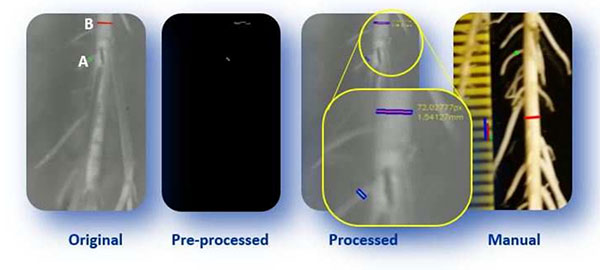

In [1]:
from IPython.display import Image
Image(filename="Images/dl_mm_root_measurement.jpg")

#### In particular, roots needed to be classified into two groups:

* “Hairy” roots
* “Non-hairy” roots

#### The “hairier” a root is, the better the root can suck up nutrients.

#### The “less hairy” the root is, the fewer nutrients it can intake, potentially leading to the plant starving and dying.

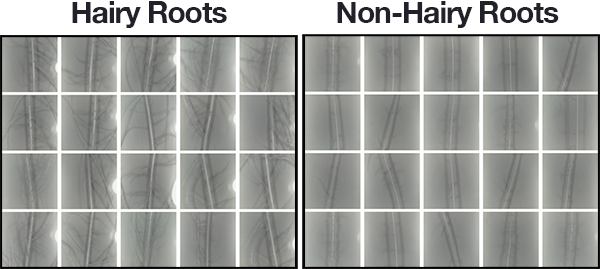

In [2]:
Image(filename="Images/dl_mm_dataset.png")

Dataset of 1,524 root images includes:

* Hairy: 748 images (left)
* Non-hairy: 776 images (right)

The original images were captured at a higher resolution of 1920×1080 pixels; however, I’ve used 256×256 pixels as a matter of convenience (and to save space/bandwidth).

The resizing was performed by:

Resizing the height to 256 pixels
And then taking the center 256-pixel crop
Since the center of the image always contained the mass of root hairs (or lack thereof), this resizing and cropping method worked quite well.

## Model Structure

* Input Layer 
* Conv Layer 1
* Activation Layer 1
* Max Pooling Layer 1
* Dropout Layer 1
* Conv Layer 2
* Activation Layer 2
* Max Pooling Layer 2
* Dropout Layer 2
* Conv Layer 3
* Activation Layer 3
* Max Pooling Layer 3
* Dropout Layer 3
* Flatten
* Dense Layer 1
* Activation Layer 4
* Dropout Layer 4
* Dense Layer 2
* Activation Layer 5

# Code

In [3]:
# For plotting
import matplotlib
matplotlib.use("Agg")

In [4]:
# Import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from imutils import build_montages
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

Using TensorFlow backend.


In [5]:
print("Loading images...")
imagePaths = list(paths.list_images('dataset'))

Loading images...


In [6]:
data = []
labels = []

for imagePath in imagePaths:
    # Extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the image, convert it to grayscale, and resize it to be a
    # fixed 64x64 pixels, ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (64, 64))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [7]:
# Converting data into Numpy Array, scaling it to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
# Reshaping for channel dimension
data = data.reshape((data.shape[0], data.shape[1], data.shape[2], 1))

In [8]:
# Encoding Labels
LE = LabelEncoder()
labels = LE.fit_transform(labels)

In [9]:
# One-hot Encoding
labels = np_utils.to_categorical(labels, 2)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, stratify=labels, random_state=42)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [12]:
print("Compiling model...")

epochs = int(input("Enter the no. of epochs: "))

optimizer = Adam(lr=1e-4, decay=1e-4 / epochs) # no. of epochs = 100

# Model
def convNet(width, height, depth, classes, reg):
    
    # initialize the model along with the input shape to be
    # "channels last"
    model = Sequential()
    inputShape = (height, width, depth)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)

    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(64, (11, 11), input_shape=inputShape, padding="same", kernel_regularizer=reg))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(128, (5, 5), padding="same", kernel_regularizer=reg))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # third (and final) CONV => RELU => POOL layers
    model.add(Conv2D(256, (3, 3), padding="same", kernel_regularizer=reg))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # first and only set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=reg))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

Compiling model...
Enter the no. of epochs: 100


In [13]:
model = convNet(width=64, height=64, depth=1, classes=len(LE.classes_), reg=l2(0.0002))
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [14]:
print("Training network for {} epochs...".format(epochs))
ConvNet = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=epochs, verbose=1)
print("Training Completed!")

Training network for 100 epochs...
Train on 918 samples, validate on 453 samples
Epoch 1/100
918/918 [==============================] - 11s 12ms/step - loss: 0.9491 - acc: 0.4771 - val_loss: 0.9264 - val_acc: 0.5298
Epoch 2/100
918/918 [==============================] - 5s 5ms/step - loss: 0.9211 - acc: 0.5163 - val_loss: 0.9120 - val_acc: 0.4702
Epoch 3/100
918/918 [==============================] - 5s 5ms/step - loss: 0.9055 - acc: 0.5000 - val_loss: 0.8986 - val_acc: 0.4702
Epoch 4/100
918/918 [==============================] - 5s 5ms/step - loss: 0.8904 - acc: 0.5272 - val_loss: 0.8830 - val_acc: 0.4702
Epoch 5/100
918/918 [==============================] - 5s 5ms/step - loss: 0.8699 - acc: 0.5773 - val_loss: 0.8653 - val_acc: 0.4702
Epoch 6/100
918/918 [==============================] - 5s 5ms/step - loss: 0.8585 - acc: 0.5752 - val_loss: 0.8432 - val_acc: 0.6645
Epoch 7/100
918/918 [==============================] - 5s 5ms/step - loss: 0.8313 - acc: 0.6198 - val_loss: 0.7955 - va

In [15]:
print("Evaluating the network")
predictions = model.predict(X_test, batch_size=32)

Evaluating the network


In [16]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

array([[71,  4],
       [ 0, 78]], dtype=int64)

In [17]:
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=LE.classes_))

                precision    recall  f1-score   support

    hairy_root       1.00      0.95      0.97        75
non_hairy_root       0.95      1.00      0.97        78

     micro avg       0.97      0.97      0.97       153
     macro avg       0.98      0.97      0.97       153
  weighted avg       0.98      0.97      0.97       153



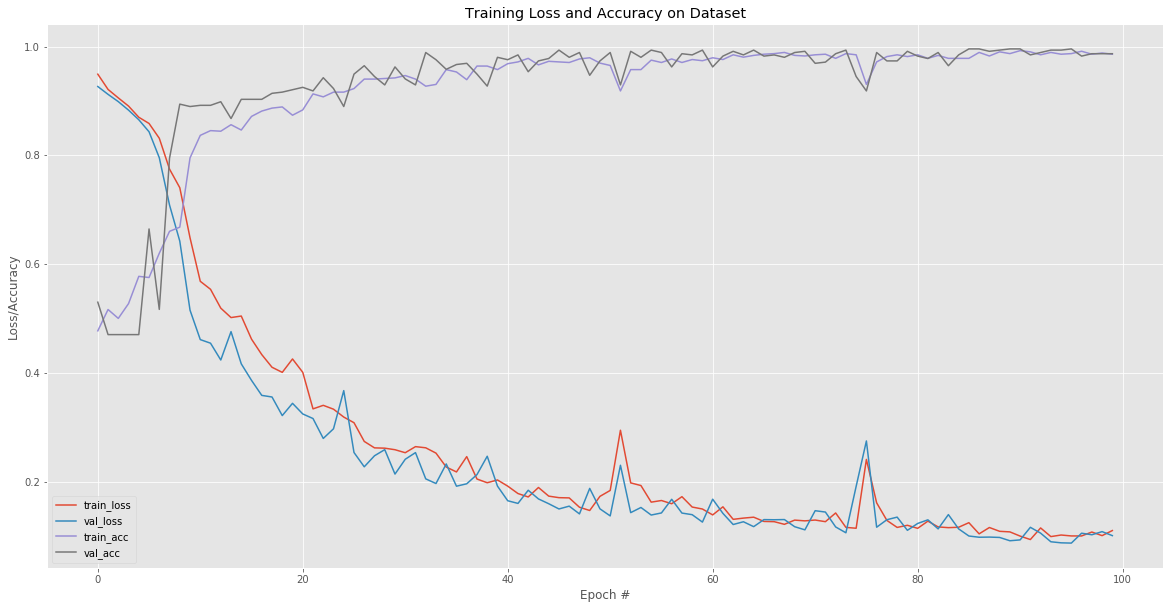

In [18]:
# Plot the training loss and accuracy
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(20, 10))
plt.plot(np.arange(0, epochs), ConvNet.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), ConvNet.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), ConvNet.history["acc"], label="train_acc")
plt.plot(np.arange(0, epochs), ConvNet.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.savefig(args["plot"])

In [19]:
# Randomly select test images
testImages = np.arange(0, y_test.shape[0])
testImages = np.random.choice(testImages, size=(25,), replace=False)
images = []

In [20]:
for ti in testImages:
    # Grab the current testing image and classify it
    
    image = np.expand_dims(X_test[ti], axis=0)
    preds = model.predict(image)
    j = preds.argmax(axis=1)[0]
    label = LE.classes_[j]

    # Rescale the image into the range [0, 255] and then resize it so
    # We can more easily visualize it
    output = (image[0] * 255).astype("uint8")
    output = np.dstack([output] * 3)
    output = cv2.resize(output, (128, 128))

    # Draw the class label on the output image and add it to the set of output images
    if label == 'non_hairy_root':
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    else:
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    images.append(output)

In [21]:
# Create a montage using 128x128 "tiles" with 5 rows and 5 columns
montage = build_montages(images, (128, 128), (5, 5))[0]

In [22]:
# Show the output montage
while True:
    cv2.imshow("Output", montage)
    if cv2.waitKey(1) == 13:  # 13 is the Enter Key
        break
cv2.destroyAllWindows()

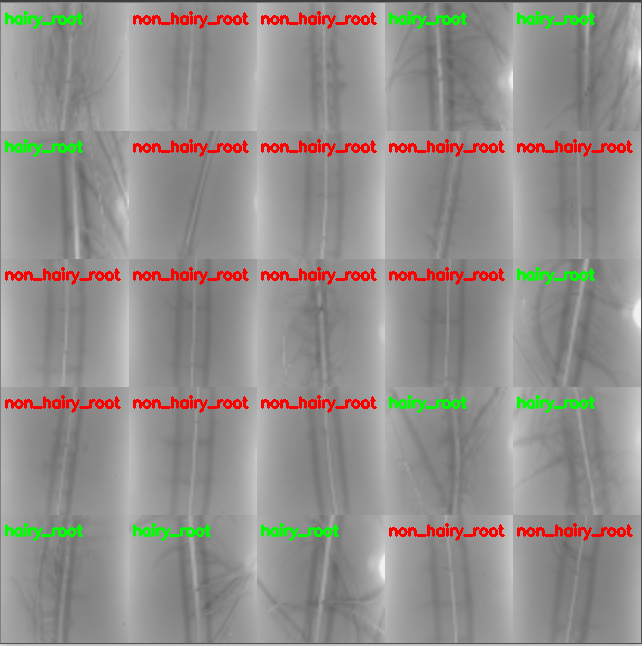

In [23]:
Image(filename="Images/output.png")